# Lesson 1 Notes
Replicate results from lesson one using data on basketball and soccer players. 

To download images, use

```
googleimagesdownload -k "basketball player" -o "basketballplayer" --limit 95
googleimagesdownload -k "soccer player" -o "soccerplayer" --limit 95
```
to download 200 hundred images of basketball players on Google Images and store them in the `basketballplayer` folder

In [1]:
import sys
sys.path.append("../fastai/") # go to parent dir

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
# data path
PATH = "/home/pspenano/Dropbox/data_science/fastai_deeplearning/pt1/data/basketball_soccer2/"
sz=224

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.backends.cudnn.enabled

True

In [8]:
os.listdir(PATH)

['models', 'train', 'tmp', 'valid']

In [9]:
os.listdir(f'{PATH}valid')


['soccerplayer', 'basketballplayer']

In [10]:
files = os.listdir(f'{PATH}valid/basketballplayer')[:5]
files

['9. Chris-Duhon-Los-Angeles-Lakers.jpg',
 '2. lebron-james-photo-u186.jpg',
 '6. 220px-Joakim-noah.jpg',
 '15. Warriors-defend-LeBron-NBA-running-fastbreak-1024x764.jpg',
 '4. maxresdefault.jpg']

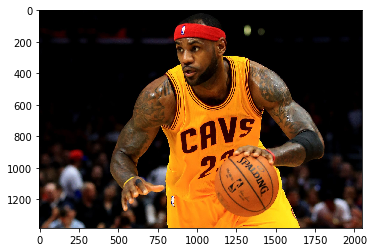

In [11]:
img = plt.imread(f'{PATH}valid/basketballplayer/{files[4]}')
plt.imshow(img);

In [12]:
img.shape

(1381, 2048, 3)

In [13]:
img[:4,:4]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

## Modeling

In [14]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.962544   0.916359   0.5       
    1      0.753096   0.361231   0.833333  
    2      0.570145   0.200982   0.866667  
    3      0.485289   0.131998   0.933333  
    4      0.451139   0.115884   0.966667  



[0.11588422, 0.9666666388511658]

# Analyze results

In [171]:
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [172]:
data.classes

['basketballplayer', 'soccerplayer']

In [173]:
log_preds = learn.predict()
log_preds.shape

(30, 2)

In [174]:
log_preds[:10]

array([[-0.07283, -2.65577],
       [-0.44261, -1.02823],
       [-0.01617, -4.13266],
       [-0.04975, -3.02554],
       [-0.07225, -2.66351],
       [-0.10899, -2.27051],
       [-0.42826, -1.05452],
       [-0.2012 , -1.70238],
       [-0.02329, -3.77117],
       [-0.00273, -5.90372]], dtype=float32)

In [175]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [176]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [177]:
probs

array([0.07024, 0.35764, 0.01604, 0.04853, 0.0697 , 0.10326, 0.34836, 0.18225, 0.02303, 0.00273, 0.19943,
       0.03724, 0.01334, 0.02812, 0.08954, 0.86641, 0.99845, 0.96136, 0.66441, 0.99287, 0.99779, 0.99947,
       0.99949, 0.99095, 0.99624, 0.99397, 0.99366, 0.98562, 0.99872, 0.99297], dtype=float32)

In [178]:
# pick 4 at random
def rand_by_mask(mask): 
    choice = np.random.choice(np.where(mask)[0], 4, replace=False)
    return choice

# randomly selected correct classification
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# uncertain classification
def rand_by_uncertain(is_correct, upper_bound, lower_bound): 
    return rand_by_mask((np.logical_and(probs<=upper_bound, probs>=lower_bound))==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Uncertain classification


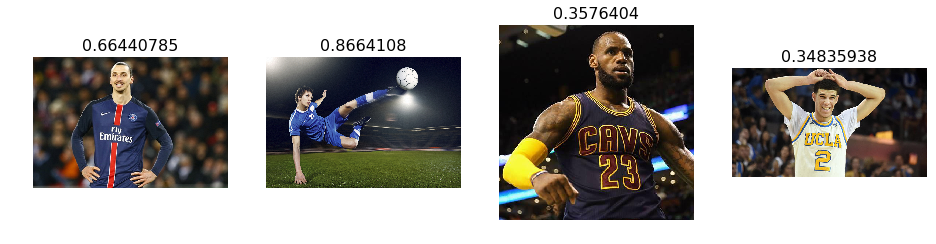

In [183]:
# certain classifications are ones that have a really low probability of being a soccer player
plot_val_with_title(rand_by_uncertain(True, 0.9, 0.2), "Uncertain classification")

Correctly classified as soccer


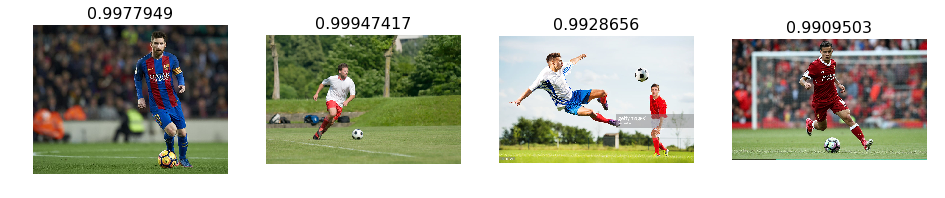

In [185]:
plot_val_with_title(rand_by_uncertain(True, 1., .90), "Correctly classified as soccer")

Correctly classified as basketball


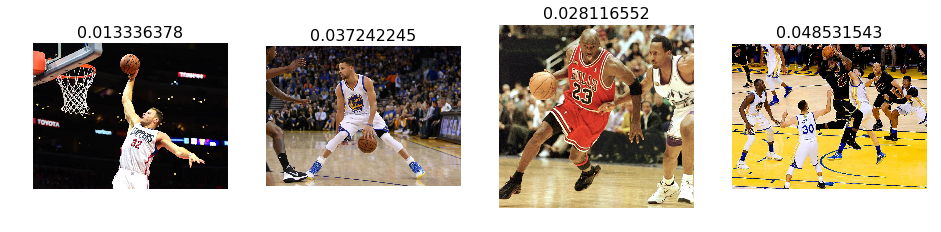

In [187]:
plot_val_with_title(rand_by_uncertain(True, 0.10, .0), "Correctly classified as basketball")